In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.3/235.7 GB disk)


In [3]:
# Import necessary libraries
import os
import cv2
import torch
import numpy as np
import time
from pathlib import Path
from collections import deque
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ultralytics import YOLO
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [4]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device with error handling
device = "cpu"
try:
    if torch.cuda.is_available():
        # Test CUDA functionality
        test_tensor = torch.zeros(1).cuda()
        _ = test_tensor + 1
        device = "cuda"
        print(f"Successfully initialized CUDA. Using device: {device}")
    else:
        print("CUDA not available. Using CPU.")
except Exception as e:
    print(f"Error initializing CUDA: {e}")
    print("Falling back to CPU.")

device = torch.device(device)

Successfully initialized CUDA. Using device: cuda


In [5]:
class PoseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        """
        Original LSTM model for pose sequence classification

        Args:
            input_size: Number of expected features in the input (keypoints * 2 for x,y)
            hidden_size: Number of features in the hidden state
            num_layers: Number of recurrent layers
            num_classes: Number of output classes (behaviors)
            dropout: Dropout rate
        """
        super(PoseLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        # x shape: (batch_size, seq_length, input_size)
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))

        # Apply attention mechanism
        attention_weights = self.attention(out)
        attention_weights = torch.softmax(attention_weights, dim=1)
        context_vector = torch.sum(attention_weights * out, dim=1)

        # Decode the hidden state to get classification
        output = self.fc(context_vector)
        return output

In [6]:
class ImprovedPoseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        """
        Enhanced LSTM model with bidirectional layers and multi-head attention

        Args:
            input_size: Number of expected features in the input (keypoints * 2 + velocity features)
            hidden_size: Number of features in the hidden state
            num_layers: Number of recurrent layers
            num_classes: Number of output classes (behaviors)
            dropout: Dropout rate
        """
        super(ImprovedPoseLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM for capturing forward and backward temporal dependencies
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0,
                          bidirectional=True)

        # Multi-head attention
        self.attention = nn.MultiheadAttention(hidden_size*2, num_heads=4)

        # Deeper classifier with batch normalization
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(hidden_size//2, num_classes)
        )

    def forward(self, x):
        try:
            # Get the device of the input tensor for creating initial hidden states
            device = x.device

        # Print input shape for debugging
            print(f"Input shape: {x.shape}")

        # Initialize hidden state with zeros, with explicit device
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device)
            c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device)

        # Forward propagate LSTM - debugging
            print("Running LSTM...")
            out, _ = self.lstm(x, (h0, c0))
            print(f"LSTM output shape: {out.shape}")

        # Apply multi-head attention - debugging
            print("Running attention...")
            out_transposed = out.transpose(0, 1)
            attn_output, _ = self.attention(out_transposed, out_transposed, out_transposed)
            attn_output = attn_output.transpose(0, 1)
            print(f"Attention output shape: {attn_output.shape}")

        # Global average pooling
            print("Running pooling...")
            out = torch.mean(attn_output, dim=1)
            print(f"Pooling output shape: {out.shape}")

        # Classification
            print("Running classification...")
            out = self.fc(out)
            print(f"Final output shape: {out.shape}")

            return out

        except Exception as e:
            print(f"Error in forward pass: {e}")
        # Print more detailed trace
            import traceback
            traceback.print_exc()
            raise

In [7]:
class PoseSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        Dataset for pose sequences and their labels

        Args:
            sequences: List of pose sequence tensors
            labels: List of behavior labels
        """
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

class AugmentedDataset(Dataset):
    def __init__(self, dataset):
        """
        Dataset wrapper that applies augmentation on-the-fly

        Args:
            dataset: Original dataset
        """
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset) * 2  # Double the dataset size

    def __getitem__(self, idx):
        real_idx = idx % len(self.dataset)
        seq, label = self.dataset[real_idx]

        # Apply augmentation for half the samples
        if idx >= len(self.dataset):
            seq_np = seq.numpy()
            aug_seq = augment_keypoints(seq_np)
            seq = torch.FloatTensor(aug_seq)

        return seq, label

def create_sliding_windows(keypoints_sequence, window_size, step_size):
    """
    Create sliding windows from a continuous sequence of keypoints

    Args:
        keypoints_sequence: Numpy array of shape (total_frames, num_keypoints*2)
        window_size: Number of frames in each window
        step_size: Number of frames to slide the window

    Returns:
        List of windowed sequences
    """
    windows = []
    for i in range(0, len(keypoints_sequence) - window_size + 1, step_size):
        windows.append(keypoints_sequence[i:i + window_size])
    return windows

def prepare_dataset(data_path, window_size=25, step_size=5):
    """
    Prepare dataset from saved keypoints sequences

    Args:
        data_path: Path to directory containing saved keypoint sequences
        window_size: Number of frames in each sequence window
        step_size: Number of frames to slide between windows

    Returns:
        Dataset ready for training
    """
    sequences = []
    labels = []
    behavior_names = []

    # Load all saved sequences
    behavior_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    print(f"Found {len(behavior_dirs)} behavior classes: {behavior_dirs}")

    for behavior_idx, behavior in enumerate(behavior_dirs):
        behavior_path = os.path.join(data_path, behavior)
        sequence_files = [f for f in os.listdir(behavior_path) if f.endswith('.npy')]

        behavior_names.append(behavior)
        print(f"Processing {behavior}: {len(sequence_files)} sequence files")

        for seq_file in sequence_files:
            keypoints_seq = np.load(os.path.join(behavior_path, seq_file))

            if len(keypoints_seq) < window_size:
                print(f"Warning: Sequence {seq_file} too short ({len(keypoints_seq)} frames), skipping")
                continue

            # Create sliding windows for this sequence
            windows = create_sliding_windows(keypoints_seq, window_size, step_size)

            # Add each window as a separate training example
            for window in windows:
                if len(window) == window_size:  # Ensure complete window
                    sequences.append(window)
                    labels.append(behavior_idx)

    print(f"Created dataset with {len(sequences)} examples")

    # Check class balance
    class_counts = {}
    for label in labels:
        class_counts[label] = class_counts.get(label, 0) + 1

    print("Class distribution:")
    for idx, count in class_counts.items():
        print(f"  {behavior_names[idx]}: {count} examples ({count/len(labels)*100:.1f}%)")

    # Convert to tensors
    sequences_tensor = [torch.FloatTensor(seq) for seq in sequences]
    labels_tensor = torch.LongTensor(labels)

    return PoseSequenceDataset(sequences_tensor, labels_tensor), behavior_names

In [8]:
def augment_keypoints(keypoints_sequence, target_length=None):
    """
    Apply augmentation to keypoint sequences with consistent length

    Args:
        keypoints_sequence: Numpy array of shape (seq_len, num_features)
        target_length: Target sequence length (optional)

    Returns:
        Augmented sequence
    """
    augmented = keypoints_sequence.copy()

    # Get original length
    orig_length = len(augmented)

    # Set target length if not provided
    if target_length is None:
        target_length = orig_length

    # Add small random noise to positions (jitter)
    noise = np.random.normal(0, 0.01, augmented.shape)
    augmented += noise

    # Mirror horizontally (swap left/right keypoints)
    if np.random.random() > 0.5:
        pairs = [(1,2), (3,4), (5,6), (7,8), (9,10), (11,12), (13,14), (15,16)]
        num_features = augmented.shape[1]
        num_keypoints = num_features // 2

        # Only apply to keypoint features (not derived features)
        for pair in pairs:
            if pair[1] < num_keypoints:
                left_idx = pair[0] * 2  # x coordinate of left keypoint
                right_idx = pair[1] * 2  # x coordinate of right keypoint
                # Swap coordinates
                augmented[:, left_idx], augmented[:, right_idx] = \
                    augmented[:, right_idx].copy(), augmented[:, left_idx].copy()
                augmented[:, left_idx+1], augmented[:, right_idx+1] = \
                    augmented[:, right_idx+1].copy(), augmented[:, left_idx+1].copy()

    # Time warping with length preservation
    if np.random.random() > 0.5:
        # Choose random segment to stretch/compress
        segment_start = np.random.randint(0, orig_length // 3)
        segment_end = np.random.randint(2 * orig_length // 3, orig_length)
        segment_length = segment_end - segment_start

        # Choose warping factor
        factor = np.random.uniform(0.7, 1.3)
        warped_length = int(segment_length * factor)

        # Create warped segment
        if segment_length > 3 and warped_length > 3:
            indices = np.linspace(segment_start, segment_end - 1, warped_length)
            warped_segment = np.array([augmented[int(i)] for i in indices])

            # Replace segment while maintaining total length
            result_length = orig_length - segment_length + warped_length
            if result_length > target_length:
                # If too long, trim ends
                trim = result_length - target_length
                left_trim = trim // 2
                right_trim = trim - left_trim
                result = np.vstack([
                    augmented[:segment_start][left_trim:],
                    warped_segment,
                    augmented[segment_end:][:-right_trim if right_trim > 0 else None]
                ])
            elif result_length < target_length:
                # If too short, repeat end points
                padding = target_length - result_length
                left_pad = padding // 2
                right_pad = padding - left_pad
                left_padding = np.tile(augmented[0], (left_pad, 1))
                right_padding = np.tile(augmented[-1], (right_pad, 1))
                result = np.vstack([
                    left_padding,
                    augmented[:segment_start],
                    warped_segment,
                    augmented[segment_end:],
                    right_padding
                ])
            else:
                result = np.vstack([
                    augmented[:segment_start],
                    warped_segment,
                    augmented[segment_end:]
                ])

            # Ensure we have exactly the target length
            if len(result) != target_length:
                if len(result) > target_length:
                    result = result[:target_length]
                else:
                    padding = np.tile(result[-1], (target_length - len(result), 1))
                    result = np.vstack([result, padding])

            augmented = result

    # Ensure the final sequence has the target length
    if len(augmented) != target_length:
        if len(augmented) > target_length:
            # Center crop
            start = (len(augmented) - target_length) // 2
            augmented = augmented[start:start + target_length]
        else:
            # Pad by repeating last frame
            padding = np.tile(augmented[-1], (target_length - len(augmented), 1))
            augmented = np.vstack([augmented, padding])

    return augmented



def normalize_keypoints(keypoints_sequence):
    """
    Normalize keypoints to be invariant to position and scale

    Args:
        keypoints_sequence: Numpy array of shape (seq_len, num_keypoints*2)

    Returns:
        Normalized keypoints
    """
    seq_len, num_features = keypoints_sequence.shape
    num_keypoints = num_features // 2

    # Reshape to separate x,y coordinates
    keypoints = keypoints_sequence.reshape(seq_len, num_keypoints, 2)

    normalized_keypoints = np.zeros_like(keypoints)

    for i in range(seq_len):
        # Find central point (mid-hip)
        if num_keypoints > 12:  # COCO format
            # Use mid-hip as reference (average of left and right hip)
            left_hip = keypoints[i, 11]
            right_hip = keypoints[i, 12]
            center = (left_hip + right_hip) / 2
        else:
            # If hips not available, use the average of all points as center
            center = np.mean(keypoints[i], axis=0)

        # Center all points
        centered = keypoints[i] - center

        # Calculate scale (use hip width or maximum distance from center)
        if num_keypoints > 12:
            # Use distance between hips for scale
            hip_width = np.linalg.norm(right_hip - left_hip)
            scale = max(hip_width, 1e-6)  # Prevent division by zero
        else:
            # Use maximum distance from center as scale
            max_dist = np.max(np.linalg.norm(centered, axis=1))
            scale = max(max_dist, 1e-6)

        # Normalize by scale
        normalized_keypoints[i] = centered / scale

    # Reshape back to original format
    return normalized_keypoints.reshape(seq_len, num_features)


def add_velocity_features(keypoints_sequence):
    """
    Add velocity features to keypoint sequence

    Args:
        keypoints_sequence: Numpy array of shape (seq_len, num_features)

    Returns:
        Sequence with velocity features added
    """
    # Calculate velocity (frame-to-frame differences)
    velocity = np.zeros_like(keypoints_sequence)
    velocity[1:] = keypoints_sequence[1:] - keypoints_sequence[:-1]

    # Concatenate original keypoints and velocity
    return np.concatenate([keypoints_sequence, velocity], axis=1)


def add_advanced_features(keypoints_sequence):
    """
    Add advanced biomechanical features from keypoints

    Args:
        keypoints_sequence: Numpy array of shape (seq_len, num_keypoints*2)

    Returns:
        Sequence with advanced features added
    """
    seq_len, num_features = keypoints_sequence.shape
    num_keypoints = num_features // 2

    # Reshape to have explicit keypoint coordinates
    keypoints = keypoints_sequence.reshape(seq_len, num_keypoints, 2)

    # Initialize additional features
    advanced_features = []

    for frame in keypoints:
        frame_features = []

        # Nose position (0)
        nose = frame[0]

        # Calculate hand to face distances
        left_wrist = frame[9] if num_keypoints > 9 else np.zeros(2)
        right_wrist = frame[10] if num_keypoints > 10 else np.zeros(2)

        left_hand_to_face = np.linalg.norm(left_wrist - nose)
        right_hand_to_face = np.linalg.norm(right_wrist - nose)

        # Calculate body orientation (angle between shoulders)
        if num_keypoints > 6:  # Ensure we have shoulder keypoints
            left_shoulder = frame[5]
            right_shoulder = frame[6]

            # Shoulder angle
            shoulder_vector = right_shoulder - left_shoulder
            orientation = np.arctan2(shoulder_vector[1], shoulder_vector[0])

            # Upper body position relative to shoulders midpoint
            shoulders_mid = (left_shoulder + right_shoulder) / 2
            neck_to_mid = nose - shoulders_mid
            neck_distance = np.linalg.norm(neck_to_mid)
            neck_angle = np.arctan2(neck_to_mid[1], neck_to_mid[0])

            frame_features.extend([orientation, neck_distance, neck_angle])

        # Add hand distances
        frame_features.extend([left_hand_to_face, right_hand_to_face])

        advanced_features.append(frame_features)

    # Convert to numpy array
    advanced_features = np.array(advanced_features)

    # Concatenate original keypoints with advanced features
    return np.concatenate([keypoints_sequence, advanced_features], axis=1)








In [9]:
def add_behavior_features(keypoints_sequence):
    """
    Add specialized features for behavior classification

    Args:
        keypoints_sequence: Numpy array of shape (seq_len, num_features)

    Returns:
        Sequence with behavior-specific features
    """
    seq_len, num_features = keypoints_sequence.shape

    # We need to work with the original keypoints only, not derived features
    # Determine the number of keypoints in the original data
    # If velocity features were added, the first half contains the original keypoints
    original_features = num_features
    if num_features % 2 == 0 and num_features > 34:
        # The original keypoints are probably in the first half
        original_features = num_features // 2
        if original_features % 2 == 0:  # Ensure it's even (x,y pairs)
            # Extract just the original keypoint data
            original_keypoints = keypoints_sequence[:, :original_features]
        else:
            # If not even, just use the whole array
            original_keypoints = keypoints_sequence
    else:
        # Use the whole array
        original_keypoints = keypoints_sequence

    # Ensure the number of features is even (for x,y pairs)
    if original_features % 2 != 0:
        print(f"Warning: Number of features ({original_features}) is not even, cannot interpret as keypoints")
        # Return the original sequence with a dummy feature added
        dummy_feature = np.zeros((seq_len, 1))
        return np.concatenate([keypoints_sequence, dummy_feature], axis=1)

    # Compute number of keypoints based on features
    num_keypoints = original_features // 2

    # Reshape to have explicit keypoint coordinates
    try:
        keypoints = original_keypoints.reshape(seq_len, num_keypoints, 2)
    except ValueError as e:
        print(f"Error reshaping keypoints: {e}")
        print(f"Original shape: {original_keypoints.shape}, trying to reshape to: {(seq_len, num_keypoints, 2)}")
        # Return the original sequence with a dummy feature
        dummy_feature = np.zeros((seq_len, 5))  # Add some dummy features
        return np.concatenate([keypoints_sequence, dummy_feature], axis=1)

    # Initialize additional features
    behavior_features = []

    for i in range(seq_len):
        frame_features = []

        # 1. Hand flapping features (wrist movement patterns)
        if i > 0 and i < seq_len - 1 and num_keypoints > 10:
            try:
                # Get wrist positions for consecutive frames
                left_wrist_prev = keypoints[i-1, 9]
                left_wrist = keypoints[i, 9]
                left_wrist_next = keypoints[i+1, 9]

                right_wrist_prev = keypoints[i-1, 10]
                right_wrist = keypoints[i, 10]
                right_wrist_next = keypoints[i+1, 10]

                # Calculate vertical and horizontal velocities
                left_vx = left_wrist[0] - left_wrist_prev[0]
                left_vy = left_wrist[1] - left_wrist_prev[1]
                left_ax = (left_wrist_next[0] - left_wrist[0]) - left_vx
                left_ay = (left_wrist_next[1] - left_wrist[1]) - left_vy

                right_vx = right_wrist[0] - right_wrist_prev[0]
                right_vy = right_wrist[1] - right_wrist_prev[1]
                right_ax = (right_wrist_next[0] - right_wrist[0]) - right_vx
                right_ay = (right_wrist_next[1] - right_wrist[1]) - right_vy

                # Add wrist velocity and acceleration features
                frame_features.extend([left_vx, left_vy, left_ax, left_ay,
                                      right_vx, right_vy, right_ax, right_ay])

                # Direction changes
                left_direction_change_x = float(np.sign(left_vx) != np.sign(left_wrist_next[0] - left_wrist[0]))
                left_direction_change_y = float(np.sign(left_vy) != np.sign(left_wrist_next[1] - left_wrist[1]))
                right_direction_change_x = float(np.sign(right_vx) != np.sign(right_wrist_next[0] - right_wrist[0]))
                right_direction_change_y = float(np.sign(right_vy) != np.sign(right_wrist_next[1] - right_wrist[1]))

                frame_features.extend([
                    left_direction_change_x, left_direction_change_y,
                    right_direction_change_x, right_direction_change_y
                ])
            except (IndexError, ValueError) as e:
                print(f"Warning: Error calculating hand features: {e}")
                frame_features.extend([0.0] * 12)  # Add zeros for missing features
        else:
            # Padding for first and last frames or when not enough keypoints
            frame_features.extend([0.0] * 12)

        # 2. Head movement features
        if num_keypoints > 0:
            try:
                nose = keypoints[i, 0]

                # Calculate head movement if we have enough frames
                if i > 0:
                    nose_prev = keypoints[i-1, 0]
                    head_vx = nose[0] - nose_prev[0]
                    head_vy = nose[1] - nose_prev[1]
                    head_speed = np.sqrt(head_vx**2 + head_vy**2)

                    # Head movement direction
                    if abs(head_vx) > 1e-6:  # Avoid division by zero
                        head_vertical_ratio = abs(head_vy) / abs(head_vx)
                    else:
                        head_vertical_ratio = 1.0 if abs(head_vy) > 1e-6 else 0.0

                    frame_features.extend([head_vx, head_vy, head_speed, head_vertical_ratio])
                else:
                    frame_features.extend([0.0, 0.0, 0.0, 0.0])
            except (IndexError, ValueError) as e:
                print(f"Warning: Error calculating head features: {e}")
                frame_features.extend([0.0] * 4)  # Add zeros for missing features
        else:
            frame_features.extend([0.0] * 4)

        # Add to behavior features
        behavior_features.append(frame_features)

    # Convert to numpy array
    behavior_features = np.array(behavior_features)

    # Ensure we don't have any NaN values
    behavior_features = np.nan_to_num(behavior_features)

    # Concatenate with original features
    return np.concatenate([keypoints_sequence, behavior_features], axis=1)

In [10]:
def preprocess_dataset(dataset, add_velocity=True, add_advanced=True, add_behavior=True):
    """
    Apply enhanced preprocessing to the entire dataset

    Args:
        dataset: Dataset object with sequences and labels
        add_velocity: Whether to add velocity features
        add_advanced: Whether to add advanced biomechanical features
        add_behavior: Whether to add behavior-specific features

    Returns:
        Preprocessed dataset
    """
    preprocessed = []

    # Track feature dimensions
    original_dim = None
    velocity_dim = None
    advanced_dim = None
    behavior_dim = None

    for seq, label in dataset:
        # Convert tensor to numpy for preprocessing
        seq_np = seq.numpy()

        # Track original dimension
        if original_dim is None:
            original_dim = seq_np.shape[1]
            print(f"Original feature dimension: {original_dim}")

        # First normalize keypoints
        seq_np = normalize_keypoints(seq_np)

        # Apply velocity features
        if add_velocity:
            seq_np = add_velocity_features(seq_np)
            if velocity_dim is None:
                velocity_dim = seq_np.shape[1]
                print(f"After velocity features: {velocity_dim}")

        # Apply advanced features
        if add_advanced:
            seq_np = add_advanced_features(seq_np)
            if advanced_dim is None:
                advanced_dim = seq_np.shape[1]
                print(f"After advanced features: {advanced_dim}")

        # Apply behavior features
        if add_behavior:
            # If we've added velocity features, we only want to use the original keypoints
            # for behavior feature calculation
            if add_velocity and not add_advanced:
                # Extract just the original keypoints for behavior features
                original_keypoints = seq_np[:, :original_dim]
                behavior_features = add_behavior_features(original_keypoints)
                # Only keep the new features
                behavior_features = behavior_features[:, original_dim:]
                # Combine with existing features
                seq_np = np.concatenate([seq_np, behavior_features], axis=1)
            else:
                seq_np = add_behavior_features(seq_np)

            if behavior_dim is None:
                behavior_dim = seq_np.shape[1]
                print(f"After behavior features: {behavior_dim}")

        # Convert back to tensor
        enhanced_seq_tensor = torch.FloatTensor(seq_np)
        preprocessed.append((enhanced_seq_tensor, label))

    return preprocessed

In [11]:
#-----------------------------------------
# Keypoint Extraction with YOLOv11-Pose
#-----------------------------------------

def tensor_to_numpy(tensor):
    """
    Safely convert tensor to numpy array regardless of device
    """
    if tensor is None:
        return None
    if isinstance(tensor, np.ndarray):
        return tensor
    if torch.is_tensor(tensor):
        if tensor.is_cuda:
            return tensor.detach().cpu().numpy()
        else:
            return tensor.detach().numpy()
    return np.array(tensor)

In [12]:
class PoseExtractor:
    def __init__(self, model_path="yolo11n-pose.pt", conf_threshold=0.25):
        """
        Initialize the pose extractor with YOLOv11-Pose

        Args:
            model_path: Path to the YOLOv11-Pose model weights
            conf_threshold: Confidence threshold for detection
        """
        try:
            # Try to load with CUDA if available
            self.model = YOLO(model_path)
        except Exception as e:
            print(f"Error loading YOLO model: {e}")
            print("Trying to load with CPU only...")

            # Force CPU loading
            import os
            os.environ['CUDA_VISIBLE_DEVICES'] = ''
            self.model = YOLO(model_path)

        self.conf_threshold = conf_threshold

    def _to_numpy(self, tensor):
        """Safely convert tensor to numpy array regardless of device"""
        return tensor_to_numpy(tensor)

    def extract_keypoints(self, frame):
        """
        Extract keypoints from a single frame

        Args:
            frame: Input image frame

        Returns:
            Normalized keypoints array for the person with highest confidence,
            or None if no person is detected
        """
        results = self.model(frame, conf=self.conf_threshold)

        # Check if any person detected
        if len(results) == 0 or not hasattr(results[0], 'keypoints') or results[0].keypoints is None:
            return None

        # Get keypoints for the person with highest confidence
        # YOLOv11-Pose returns keypoints.data as x, y, confidence values
        kpts = results[0].keypoints.data

        if len(kpts) == 0:  # No keypoints detected
            return None

        # Get the person with highest confidence
        best_person_idx = 0
        if len(kpts) > 1:  # If multiple people detected
            # Calculate average confidence for each person
            avg_confs = []
            for kpt in kpts:
                # Safely convert to numpy first
                kpt_np = self._to_numpy(kpt)
                avg_confs.append(np.mean(kpt_np[:, 2]))
            best_person_idx = np.argmax(avg_confs)

        # Get keypoints for the best person
        keypoints = kpts[best_person_idx]

        # Normalize keypoints
        img_height, img_width = frame.shape[:2]

        # Always make a CPU copy before any operations
        keypoints_cpu = keypoints.detach().cpu()

        keypoints_normalized = keypoints_cpu.clone()
        keypoints_normalized[:, 0] /= img_width  # Normalize x coordinates
        keypoints_normalized[:, 1] /= img_height  # Normalize y coordinates

        # Flatten to [x1, y1, x2, y2, ...] - Always ensure we're on CPU
        keypoints_flat = keypoints_normalized[:, :2].reshape(-1).numpy()

        return keypoints_flat
    def process_video(self, video_path, output_file=None, display=False, max_frames=None):
        """
        Process video file to extract keypoints sequence

        Args:
            video_path: Path to input video file
            output_file: Path to save keypoints sequence
            display: Whether to display the detection results
            max_frames: Maximum number of frames to process

        Returns:
            Sequence of keypoints
        """
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error opening video file {video_path}")
            return None

        frame_count = 0
        keypoints_sequence = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if max_frames is not None and frame_count >= max_frames:
                break

            # Extract keypoints from the frame
            keypoints = self.extract_keypoints(frame)

            if keypoints is not None:
                keypoints_sequence.append(keypoints)

                # Display if required
                if display:
                    # Draw the pose estimation results
                    result_frame = self.model(frame, conf=self.conf_threshold)[0].plot()

                    # Check if in Colab
                    try:
                        from google.colab import widgets
                        from google.colab.patches import cv2_imshow
                        cv2_imshow(result_frame)
                        from IPython.display import clear_output
                        if frame_count % 5 == 0:  # Clear output every 5 frames to avoid flooding
                            clear_output(wait=True)
                    except:
                        # Not in Colab, use cv2.imshow
                        cv2.imshow("YOLOv11-Pose", result_frame)
                        if cv2.waitKey(1) & 0xFF == ord('q'):
                            break

            frame_count += 1

        cap.release()
        if display and 'google.colab' not in str(get_ipython()):
            cv2.destroyAllWindows()

        # Convert to numpy array
        if len(keypoints_sequence) > 0:
            # Check if all sequences have the same shape
            shapes = [len(kp) for kp in keypoints_sequence]
            if min(shapes) != max(shapes):
                print(f"Warning: Inconsistent keypoint dimensions. Min: {min(shapes)}, Max: {max(shapes)}")
                # Homogenize to the most common length
                most_common_shape = max(set(shapes), key=shapes.count)

                for i in range(len(keypoints_sequence)):
                    if len(keypoints_sequence[i]) != most_common_shape:
                        if len(keypoints_sequence[i]) < most_common_shape:
                            # Pad with zeros
                            keypoints_sequence[i] = np.pad(
                                keypoints_sequence[i],
                                (0, most_common_shape - len(keypoints_sequence[i])),
                                'constant'
                            )
                        else:
                            # Truncate
                            keypoints_sequence[i] = keypoints_sequence[i][:most_common_shape]

            keypoints_sequence = np.array(keypoints_sequence)
        else:
            print("No keypoints detected in the video")
            return None

        # Save if output file specified
        if output_file is not None and len(keypoints_sequence) > 0:
            os.makedirs(os.path.dirname(output_file), exist_ok=True)
            np.save(output_file, keypoints_sequence)
            print(f"Saved keypoints sequence to {output_file}")

        return keypoints_sequence

In [13]:
#-----------------------------------------
# Training and Evaluation Functions
#-----------------------------------------

def train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001):
    """
    Standard training loop for LSTM model
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # History for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Early stopping variables - add these
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track statistics
            train_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / train_total
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for sequences, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                sequences = sequences.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(sequences)
                loss = criterion(outputs, labels)

                # Track statistics
                val_loss += loss.item() * sequences.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        # Update learning rate
        scheduler.step(val_loss)

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history


In [14]:
def improved_train_model(model, train_loader, val_loader, num_epochs=60, learning_rate=3e-4):
    """
    Enhanced training loop with early stopping and better optimization

    Args:
        model: Neural network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Maximum number of training epochs
        learning_rate: Initial learning rate

    Returns:
        Trained model and training history
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Cosine annealing scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=learning_rate/100
    )

    # Early stopping
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    best_model_state = None

    # History for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'lr': []
    }

    try:
        # Training loop
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                sequences = sequences.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(sequences)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                # Track statistics
                train_loss += loss.item() * sequences.size(0)
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            train_loss = train_loss / train_total
            train_acc = train_correct / train_total

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for sequences, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                    sequences = sequences.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    outputs = model(sequences)
                    loss = criterion(outputs, labels)

                    # Track statistics
                    val_loss += loss.item() * sequences.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss = val_loss / val_total
            val_acc = val_correct / val_total

            # Update learning rate
            current_lr = optimizer.param_groups[0]['lr']
            scheduler.step()

            # Update history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['lr'].append(current_lr)

            print(f"Epoch {epoch+1}/{num_epochs}: "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
                f"LR: {current_lr:.6f}")

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break

        # Load best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        return model, history

    except Exception as e:
        print(f"Error in training: {e}")
        import traceback
        traceback.print_exc()
        # Return the model and history accumulated so far
        if len(history['train_loss']) > 0:
            return model, history
        else:
            raise  # Re-raise the exception if we have no training history

In [15]:
def collect_data(input_videos_dir, output_dir):
    """
    Collect keypoints data from videos

    Args:
        input_videos_dir: Directory with videos organized by behavior class
        output_dir: Directory to save extracted keypoints
    """
    pose_extractor = PoseExtractor()

    # Iterate through behavior directories
    for behavior in os.listdir(input_videos_dir):
        behavior_dir = os.path.join(input_videos_dir, behavior)
        if not os.path.isdir(behavior_dir):
            continue

        # Create output directory for this behavior
        behavior_out_dir = os.path.join(output_dir, behavior)
        os.makedirs(behavior_out_dir, exist_ok=True)

        # Process each video in this behavior directory
        for video_file in os.listdir(behavior_dir):
            if not video_file.lower().endswith(('.mp4', '.avi', '.mov')):
                continue

            video_path = os.path.join(behavior_dir, video_file)
            output_file = os.path.join(behavior_out_dir, f"{os.path.splitext(video_file)[0]}.npy")

            print(f"Processing {video_path} -> {output_file}")
            pose_extractor.process_video(video_path, output_file)

In [16]:
def pad_sequence(sequences, batch_first=False, padding_value=0.0):
    """
    Pad a list of variable length Tensors with zeros to match longest sequence

    Args:
        sequences: List of tensors of shape [L, *]
        batch_first: If True, batch dimension is first dimension (L, B, *)
        padding_value: Value to pad with

    Returns:
        Tensor of shape (B, L, *) or (L, B, *) depending on batch_first
    """
    max_len = max([s.size(0) for s in sequences])
    trailing_dims = sequences[0].size()[1:]

    if batch_first:
        out_dims = (len(sequences), max_len) + trailing_dims
    else:
        out_dims = (max_len, len(sequences)) + trailing_dims

    out_tensor = sequences[0].new_full(out_dims, padding_value)
    for i, tensor in enumerate(sequences):
        length = tensor.size(0)
        # use index notation to prevent duplicate references to the tensor
        if batch_first:
            out_tensor[i, :length, ...] = tensor
        else:
            out_tensor[:length, i, ...] = tensor

    return out_tensor

class PadCollate:
    """
    Custom collate function to pad sequences in a batch
    """
    def __init__(self, dim=0):
        self.dim = dim

    def __call__(self, batch):
        """
        Args:
            batch: List of (sequence, label)

        Returns:
            Padded sequences, stacked labels
        """
        # Find sequences and labels
        sequences = [item[0] for item in batch]
        labels = [item[1] for item in batch]

        # Pad sequences to the same length
        padded_seqs = pad_sequence(sequences, batch_first=True)

        # Stack labels
        labels = torch.stack(labels, dim=0)

        return padded_seqs, labels

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [18]:
def plot_training_history(history):
    """
    Plot training history with improved visualization

    Args:
        history: Dictionary with training and validation metrics
    """
    plt.figure(figsize=(18, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', color='green')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='purple')
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Learning rate plot (if available)
    if 'lr' in history:
        plt.subplot(1, 3, 3)
        plt.plot(history['lr'], color='orange')
        plt.title('Learning Rate', fontsize=14)
        plt.ylabel('Learning Rate', fontsize=12)
        plt.xlabel('Epoch', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.yscale('log')

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def evaluate_model(model, test_loader, class_names):
    """
    Evaluate the model with detailed metrics

    Args:
        model: Trained model
        test_loader: DataLoader for test data
        class_names: List of class names

    Returns:
        Dictionary of evaluation metrics
    """
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Evaluating"):
            sequences = sequences.to(device)

            # Forward pass
            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)

            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Print results
    print(f"Model Evaluation Results:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right', fontsize=10)
    plt.yticks(tick_marks, class_names, fontsize=10)

    # Add labels to the plot
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': report
    }

In [19]:
class BehaviorPredictor:
    def __init__(self, model_path, pose_model_path="yolo11n-pose.pt",
                 sequence_length=25, behavior_names=None, use_advanced_features=True):
        """
        Initialize behavior predictor

        Args:
            model_path: Path to trained LSTM model
            pose_model_path: Path to YOLOv11-Pose model
            sequence_length: Length of sequence window for prediction
            behavior_names: List of behavior class names
            use_advanced_features: Whether to use advanced features during prediction
        """
        # Load the trained model
        self.model = torch.load(model_path, map_location=device)
        self.model.eval()

        # Initialize pose extractor
        self.pose_extractor = PoseExtractor(model_path=pose_model_path)

        # Initialize sequence buffer
        self.sequence_length = sequence_length
        self.keypoints_buffer = deque(maxlen=sequence_length)

        # Initialize prediction history buffer for smoothing
        self.prediction_buffer = []

        # Feature engineering flags
        self.use_advanced_features = use_advanced_features

        # Class names
        self.behavior_names = behavior_names if behavior_names else ["Unknown"]

    def predict_from_frame(self, frame):
        """
        Make prediction from a single frame with enhanced preprocessing

        Args:
            frame: Input frame

        Returns:
            Predicted behavior class and confidence
        """
        # Extract keypoints
        keypoints = self.pose_extractor.extract_keypoints(frame)

        if keypoints is None:
            return None, 0.0

        # Add to buffer
        self.keypoints_buffer.append(keypoints)

        # If we don't have enough frames yet, return None
        if len(self.keypoints_buffer) < self.sequence_length:
            return None, 0.0

        # Prepare sequence for model
        sequence = np.array(list(self.keypoints_buffer))

        # Apply the same normalization and feature engineering used during training
        try:
            # First normalize keypoints
            sequence = normalize_keypoints(sequence)

            # Add velocity features
            velocity = np.zeros_like(sequence)
            velocity[1:] = sequence[1:] - sequence[:-1]
            sequence = np.concatenate([sequence, velocity], axis=1)

            # Add advanced features if requested
            if self.use_advanced_features:
                sequence = add_advanced_features(sequence)

                # Add behavior-specific features
                sequence = add_behavior_features(sequence)

            # Convert to tensor and add batch dimension
            sequence_tensor = torch.FloatTensor(sequence).unsqueeze(0).to(device)

            # Make prediction
            with torch.no_grad():
                outputs = self.model(sequence_tensor)
                probabilities = torch.softmax(outputs, dim=1)

                # Get top 3 probabilities for smoother predictions
                topk_probs, topk_preds = torch.topk(
                    probabilities,
                    k=min(3, len(self.behavior_names)),
                    dim=1
                )

                # Apply temporal smoothing
                self.prediction_buffer.append((
                    topk_preds[0].cpu().numpy(),
                    topk_probs[0].cpu().numpy()
                ))

                # Keep last 10 predictions
                if len(self.prediction_buffer) > 10:
                    self.prediction_buffer.pop(0)

                # Weighted voting from recent predictions (more weight to recent)
                votes = {}
                for i, (preds, probs) in enumerate(self.prediction_buffer):
                    weight = 0.5 + 0.5 * i / len(self.prediction_buffer)  # More weight to recent
                    for pred, prob in zip(preds, probs):
                        pred_item = pred.item() if hasattr(pred, 'item') else int(pred)
                        prob_item = prob.item() if hasattr(prob, 'item') else float(prob)
                        votes[pred_item] = votes.get(pred_item, 0) + prob_item * weight

                # Get the prediction with most votes
                if votes:
                    predicted_class = max(votes, key=votes.get)
                    confidence = votes[predicted_class] / sum(votes.values())
                else:
                    max_prob, prediction = torch.max(probabilities, dim=1)
                    predicted_class = prediction.item()
                    confidence = max_prob.item()

                return predicted_class, confidence

        except Exception as e:
            print(f"Error during prediction: {e}")
            import traceback
            traceback.print_exc()
            return None, 0.0

    def process_video_realtime(self, video_source, output_file=None):
        """
        Process video with behavior prediction

        Args:
            video_source: Video source (0 for webcam, or file path)
            output_file: Path to save output video
        """
        # Check if running in Colab
        is_colab = 'google.colab' in str(get_ipython())

        # Import Colab's image display function if running in Colab
        if is_colab:
            from google.colab.patches import cv2_imshow

        # Open video capture
        cap = cv2.VideoCapture(video_source)
        if not cap.isOpened():
            print(f"Error opening video source {video_source}")
            return

        # Get video properties
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Video properties: {frame_width}x{frame_height}, {fps} fps, {total_frames} frames")

        # Video writer setup
        if output_file:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

        frame_count = 0
        fps_time = time.time()
        processing_times = []

        # For visualization: color map for different behaviors
        colors = [
            (0, 255, 0),   # Green
            (255, 0, 0),   # Blue
            (0, 0, 255),   # Red
            (255, 255, 0), # Cyan
            (255, 0, 255), # Magenta
            (0, 255, 255), # Yellow
            (128, 128, 0), # Navy
            (128, 0, 128), # Purple
            (0, 128, 128), # Brown
            (128, 128, 128) # Gray
        ]

        # Create a color map for behaviors
        behavior_colors = {}
        for i, name in enumerate(self.behavior_names):
            behavior_colors[name] = colors[i % len(colors)]

        # For Colab: store the last frame for display
        last_frame = None
        behavior_counts = {name: 0 for name in self.behavior_names}

        # Track the last several predictions for stability
        last_predictions = []

        # Create progress bar
        from tqdm.notebook import tqdm
        pbar = tqdm(total=total_frames)

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            start_time = time.time()

            # Get pose estimation
            pose_results = self.pose_extractor.model(frame)
            result_frame = pose_results[0].plot()

            # Make behavior prediction
            behavior_class, confidence = self.predict_from_frame(frame)

            # Calculate processing time
            process_time = time.time() - start_time
            processing_times.append(process_time)

            # Calculate FPS
            frame_count += 1
            elapsed = time.time() - fps_time
            fps = frame_count / elapsed if elapsed > 0 else 0

            if frame_count % 30 == 0:  # Reset FPS counter every 30 frames
                fps_time = time.time()
                frame_count = 0

            # Stabilize prediction display with majority voting over last few predictions
            if behavior_class is not None:
                last_predictions.append(behavior_class)
                if len(last_predictions) > 5:  # Keep last 5 predictions
                    last_predictions.pop(0)

                # Count predictions
                prediction_counts = {}
                for pred in last_predictions:
                    prediction_counts[pred] = prediction_counts.get(pred, 0) + 1

                # Display most common recent prediction
                stable_prediction = max(prediction_counts, key=prediction_counts.get)
                stable_confidence = prediction_counts[stable_prediction] / len(last_predictions)

                # Get behavior name and color
                behavior_name = self.behavior_names[stable_prediction]
                color = behavior_colors.get(behavior_name, (0, 255, 0))

                # Add behavior prediction text
                behavior_text = f"Behavior: {behavior_name} ({confidence:.2f})"
                cv2.putText(result_frame, behavior_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                           1, color, 2, cv2.LINE_AA)

                # Update behavior counts
                behavior_counts[behavior_name] += 1
            else:
                # Add collecting frames text
                cv2.putText(result_frame, "Collecting frames...", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # Add processing metrics
            avg_time = sum(processing_times[-30:]) / len(processing_times[-30:])
            cv2.putText(result_frame, f"FPS: {fps:.1f} | Proc.time: {avg_time*1000:.1f}ms",
                       (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # Write frame if output file specified
            if output_file:
                out.write(result_frame)

            # Store the last frame for Colab display
            last_frame = result_frame

            # Show frame (handle differently depending on environment)
            if is_colab:
                # In Colab, we don't show frames in real-time to avoid too much output
                if frame_count % 100 == 0:  # Show progress periodically
                    cv2_imshow(result_frame)
                    from IPython.display import clear_output
                    clear_output(wait=True)
            else:
                # For local environments, show the frame normally
                cv2.imshow("Behavior Prediction", result_frame)

                # Break if 'q' pressed
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            # Update progress bar
            pbar.update(1)

        # Close progress bar
        pbar.close()

        # For Colab: display the last processed frame
        if is_colab and last_frame is not None:
            print("Video processing complete. Last frame:")
            cv2_imshow(last_frame)

        # Release resources
        cap.release()
        if output_file:
            out.release()

        if not is_colab:
            cv2.destroyAllWindows()

        # Print behavior statistics
        total_predictions = sum(behavior_counts.values())
        if total_predictions > 0:
            print("\nBehavior Statistics:")
            for behavior, count in behavior_counts.items():
                percentage = (count / total_predictions) * 100
                print(f"  {behavior}: {count} frames ({percentage:.1f}%)")

            # Visualization of behavior distribution
            plt.figure(figsize=(10, 6))
            behaviors = list(behavior_counts.keys())
            counts = list(behavior_counts.values())
            plt.bar(behaviors, counts, color='skyblue')
            plt.title('Behavior Distribution in Video')
            plt.xlabel('Behavior')
            plt.ylabel('Frame Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig('behavior_distribution.png', dpi=300, bbox_inches='tight')
            plt.show()

        print(f"Processing complete. Output saved to: {output_file}" if output_file else "Processing complete.")

        # Return behavior statistics
        return behavior_counts


Step 1: Collecting keypoint data from videos...


100%|██████████| 5.97M/5.97M [00:00<00:00, 174MB/s]


Streaming output truncated to the last 5000 lines.
0: 384x640 2 persons, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13.4ms
Speed: 2.3ms preprocess, 13.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13.2ms
Speed: 1.8ms preprocess, 13.2ms

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 522.48it/s]


Epoch 1/30: Train Loss: 1.8052, Train Acc: 0.2455, Val Loss: 1.5541, Val Acc: 0.3187


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 473.17it/s]


Epoch 2/30: Train Loss: 1.4899, Train Acc: 0.4024, Val Loss: 1.2873, Val Acc: 0.5498


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 420.78it/s]


Epoch 3/30: Train Loss: 1.2320, Train Acc: 0.5379, Val Loss: 1.0952, Val Acc: 0.6215


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 524.30it/s]


Epoch 4/30: Train Loss: 1.1417, Train Acc: 0.5797, Val Loss: 1.1587, Val Acc: 0.5538


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 514.66it/s]


Epoch 5/30: Train Loss: 1.0417, Train Acc: 0.6002, Val Loss: 1.0044, Val Acc: 0.6375


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 490.77it/s]


Epoch 6/30: Train Loss: 0.8524, Train Acc: 0.7008, Val Loss: 0.7022, Val Acc: 0.7211


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 528.46it/s]


Epoch 7/30: Train Loss: 0.6990, Train Acc: 0.7621, Val Loss: 0.5882, Val Acc: 0.7968


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 530.76it/s]


Epoch 8/30: Train Loss: 0.5977, Train Acc: 0.8184, Val Loss: 0.6054, Val Acc: 0.8446


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 489.33it/s]


Epoch 9/30: Train Loss: 0.5905, Train Acc: 0.8090, Val Loss: 0.5537, Val Acc: 0.8406


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 531.36it/s]


Epoch 10/30: Train Loss: 0.4621, Train Acc: 0.8627, Val Loss: 0.4683, Val Acc: 0.8725


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 520.11it/s]


Epoch 11/30: Train Loss: 0.4731, Train Acc: 0.8465, Val Loss: 0.6191, Val Acc: 0.8247


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 513.61it/s]


Epoch 12/30: Train Loss: 0.4260, Train Acc: 0.8662, Val Loss: 0.5184, Val Acc: 0.8765


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 517.07it/s]


Epoch 13/30: Train Loss: 0.5401, Train Acc: 0.8159, Val Loss: 0.4630, Val Acc: 0.8765


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 469.08it/s]


Epoch 14/30: Train Loss: 0.3147, Train Acc: 0.8994, Val Loss: 0.3451, Val Acc: 0.8924


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 453.33it/s]


Epoch 15/30: Train Loss: 0.3381, Train Acc: 0.8951, Val Loss: 0.4299, Val Acc: 0.8645


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 530.17it/s]


Epoch 16/30: Train Loss: 0.3483, Train Acc: 0.8968, Val Loss: 0.5029, Val Acc: 0.8725


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 526.29it/s]


Epoch 17/30: Train Loss: 0.3472, Train Acc: 0.8960, Val Loss: 0.2820, Val Acc: 0.9044


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 487.78it/s]


Epoch 18/30: Train Loss: 0.2077, Train Acc: 0.9378, Val Loss: 0.3364, Val Acc: 0.8765


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 532.30it/s]


Epoch 19/30: Train Loss: 0.2061, Train Acc: 0.9369, Val Loss: 0.2678, Val Acc: 0.8725


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 538.73it/s]


Epoch 20/30: Train Loss: 0.2778, Train Acc: 0.9139, Val Loss: 0.4218, Val Acc: 0.8924


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 487.60it/s]


Epoch 21/30: Train Loss: 0.2306, Train Acc: 0.9318, Val Loss: 0.3213, Val Acc: 0.9084


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 505.97it/s]


Epoch 22/30: Train Loss: 0.3791, Train Acc: 0.8943, Val Loss: 0.3245, Val Acc: 0.9044


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 532.98it/s]


Epoch 23/30: Train Loss: 0.1894, Train Acc: 0.9471, Val Loss: 0.2063, Val Acc: 0.9323


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 510.64it/s]


Epoch 24/30: Train Loss: 0.1048, Train Acc: 0.9685, Val Loss: 0.1567, Val Acc: 0.9482


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 435.52it/s]


Epoch 25/30: Train Loss: 0.0974, Train Acc: 0.9685, Val Loss: 0.1861, Val Acc: 0.9442


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 500.16it/s]


Epoch 26/30: Train Loss: 0.1357, Train Acc: 0.9591, Val Loss: 0.2198, Val Acc: 0.9323


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 532.45it/s]


Epoch 27/30: Train Loss: 0.1872, Train Acc: 0.9361, Val Loss: 0.3318, Val Acc: 0.9004


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 535.44it/s]


Epoch 28/30: Train Loss: 0.2022, Train Acc: 0.9361, Val Loss: 0.2570, Val Acc: 0.9243


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 527.03it/s]


Epoch 29/30: Train Loss: 0.1680, Train Acc: 0.9446, Val Loss: 0.3114, Val Acc: 0.8884


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 484.30it/s]


Epoch 30/30: Train Loss: 0.2383, Train Acc: 0.9284, Val Loss: 0.3032, Val Acc: 0.8845

Evaluating original model:


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 518.20it/s]

Model Evaluation Results:
Overall Accuracy: 0.8775
F1 Score (weighted): 0.8790

Classification Report:
                   precision    recall  f1-score   support

Avoid_Eye_Contact       0.89      0.91      0.90        34
    Hand_Flapping       0.67      0.91      0.77        33
     Head_Banging       0.92      0.73      0.81        48
         Stimming       0.88      0.97      0.93        38
          Jumping       0.93      0.87      0.90        30
          Bitting       0.97      0.90      0.93        39
  Finger_Flicking       0.97      0.90      0.93        31

         accuracy                           0.88       253
        macro avg       0.89      0.88      0.88       253
     weighted avg       0.89      0.88      0.88       253



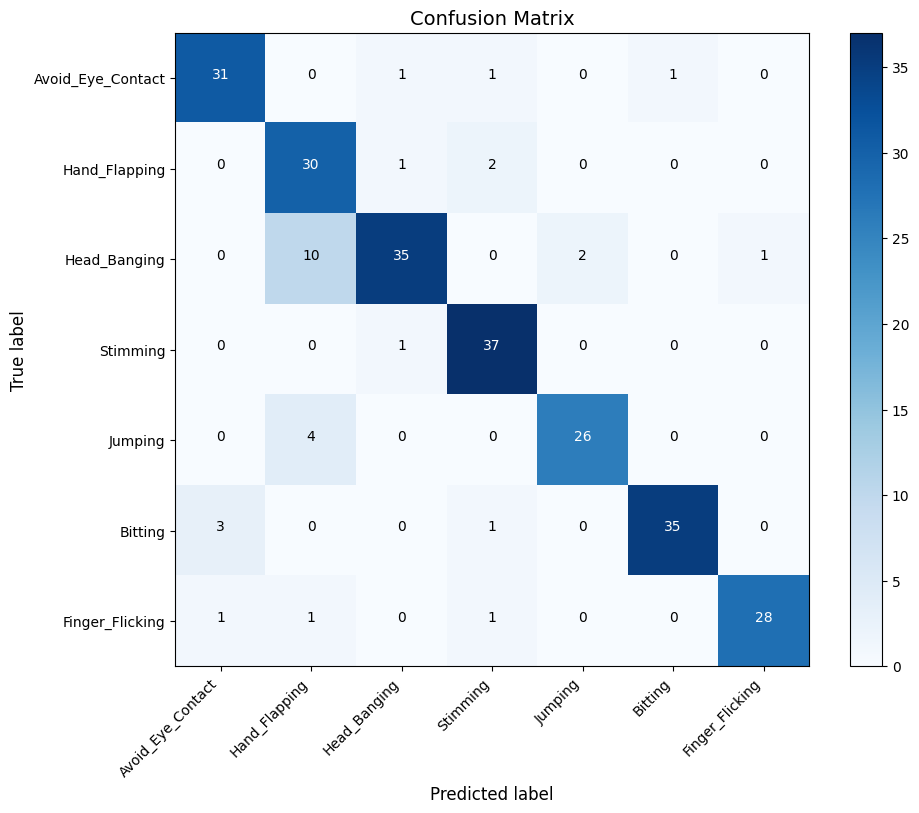

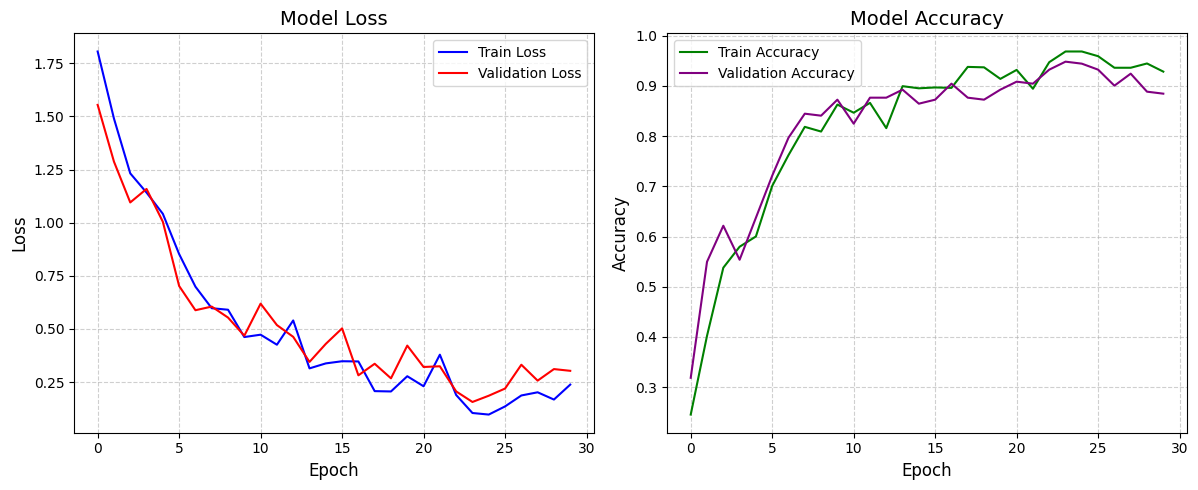


Step 3b: Preprocessing data with enhanced features...
Original feature dimension: 34
After velocity features: 68
After advanced features: 73
After behavior features: 74
Original feature dimension: 34
After velocity features: 68
After advanced features: 73
After behavior features: 74
Original feature dimension: 34
After velocity features: 68
After advanced features: 73
After behavior features: 74
Creating augmented training dataset...
Enhanced input size: 74
Expected sequence length: 25

Step 4: Training improved model...


Epoch 1/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]<ipython-input-20-dda907363265>:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(label) for label in labels], dim=0)
Epoch 1/60 [Train]:   1%|▏         | 1/74 [00:00<00:13,  5.28it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])


Epoch 1/60 [Train]:  20%|██        | 15/74 [00:00<00:01, 45.84it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 1/60 [Train]:  39%|███▉      | 29/74 [00:00<00:00, 59.06it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 1/60 [Train]:  59%|█████▉    | 44/74 [00:00<00:00, 64.81it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 1/60 [Train]:  69%|██████▉   | 51/74 [00:00<00:00, 65.34it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 1/60 [Train]:  97%|█████████▋| 72/74 [00:01<00:00, 67.57it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 1/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 58.64it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([10, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([10, 25, 512])
Running attention...
Attention output shape: torch.Size([10, 25, 512])
Running pooling...
Pooling output shape: torch.Size([10, 512])
Running classification...
Final output shape: torch.Size([10, 7])


Epoch 1/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 240.95it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 2/60 [Train]:   9%|▉         | 7/74 [00:00<00:00, 68.16it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 2/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 67.08it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 2/60 [Train]:  49%|████▊     | 36/74 [00:00<00:00, 67.40it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 2/60 [Train]:  69%|██████▉   | 51/74 [00:00<00:00, 68.91it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 2/60 [Train]:  88%|████████▊ | 65/74 [00:00<00:00, 68.32it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 2/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 67.99it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([10, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([10, 25, 512])
Runn

Epoch 2/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 250.49it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 3/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 3/60 [Train]:   8%|▊         | 6/74 [00:00<00:01, 56.22it/s]

Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([

Epoch 3/60 [Train]:  18%|█▊        | 13/74 [00:00<00:00, 61.76it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 3/60 [Train]:  27%|██▋       | 20/74 [00:00<00:00, 62.87it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 3/60 [Train]:  36%|███▋      | 27/74 [00:00<00:00, 64.28it/s]

Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM outp

Epoch 3/60 [Train]:  46%|████▌     | 34/74 [00:00<00:00, 64.79it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 3/60 [Train]:  55%|█████▌    | 41/74 [00:00<00:00, 65.54it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 3/60 [Train]:  65%|██████▍   | 48/74 [00:00<00:00, 65.52it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 3/60 [Train]:  74%|███████▍  | 55/74 [00:00<00:00, 66.09it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 3/60 [Train]:  84%|████████▍ | 62/74 [00:00<00:00, 65.53it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 3/60 [Train]:  93%|█████████▎| 69/74 [00:01<00:00, 66.19it/s]

Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])


Epoch 3/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 65.15it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([10, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([10, 25, 512])
Running attention...
Attention output shape: torch.Size([10, 25, 512])
Running pooling...
Pooling output shape: torch.Size([10, 512])
Running classification...
Final output shape: torch.Size([10, 7])


Epoch 3/60 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...


Epoch 3/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 226.94it/s]


LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 4/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 4/60 [Train]:   9%|▉         | 7/74 [00:00<00:00, 69.00it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 4/60 [Train]:  19%|█▉        | 14/74 [00:00<00:00, 67.14it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 4/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 64.53it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 4/60 [Train]:  38%|███▊      | 28/74 [00:00<00:00, 65.94it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 4/60 [Train]:  47%|████▋     | 35/74 [00:00<00:00, 65.67it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 4/60 [Train]:  57%|█████▋    | 42/74 [00:00<00:00, 66.13it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 4/60 [Train]:  66%|██████▌   | 49/74 [00:00<00:00, 66.87it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 4/60 [Train]:  76%|███████▌  | 56/74 [00:00<00:00, 66.79it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 4/60 [Train]:  85%|████████▌ | 63/74 [00:00<00:00, 66.15it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 4/60 [Train]:  95%|█████████▍| 70/74 [00:01<00:00, 65.97it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 4/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 66.14it/s]


Input shape: torch.Size([10, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([10, 25, 512])
Running attention...
Attention output shape: torch.Size([10, 25, 512])
Running pooling...
Pooling output shape: torch.Size([10, 512])
Running classification...
Final output shape: torch.Size([10, 7])


Epoch 4/60 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 4/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 217.22it/s]


LSTM output shape: torch.Size([27, 25, 512])
Running attention...
Attention output shape: torch.Size([27, 25, 512])
Running pooling...
Pooling output shape: torch.Size([27, 512])
Running classification...
Final output shape: torch.Size([27, 7])
Epoch 4/60: Train Loss: 0.1321, Train Acc: 0.9693, Val Loss: 0.0574, Val Acc: 0.9841, LR: 0.000106


Epoch 5/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 5/60 [Train]:   9%|▉         | 7/74 [00:00<00:01, 65.82it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 5/60 [Train]:  19%|█▉        | 14/74 [00:00<00:00, 67.25it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 5/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 65.36it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 5/60 [Train]:  38%|███▊      | 28/74 [00:00<00:00, 64.55it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 5/60 [Train]:  47%|████▋     | 35/74 [00:00<00:00, 64.27it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 5/60 [Train]:  57%|█████▋    | 42/74 [00:00<00:00, 65.05it/s]

Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([3

Epoch 5/60 [Train]:  66%|██████▌   | 49/74 [00:00<00:00, 65.82it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 5/60 [Train]:  76%|███████▌  | 56/74 [00:00<00:00, 66.28it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 5/60 [Train]:  85%|████████▌ | 63/74 [00:00<00:00, 67.05it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 5/60 [Train]:  95%|█████████▍| 70/74 [00:01<00:00, 64.89it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 5/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 65.13it/s]


Input shape: torch.Size([10, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([10, 25, 512])
Running attention...
Attention output shape: torch.Size([10, 25, 512])
Running pooling...
Pooling output shape: torch.Size([10, 512])
Running classification...
Final output shape: torch.Size([10, 7])


Epoch 5/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 246.62it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:   9%|▉         | 7/74 [00:00<00:01, 65.32it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:  19%|█▉        | 14/74 [00:00<00:00, 66.22it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 66.17it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:  38%|███▊      | 28/74 [00:00<00:00, 66.31it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:  47%|████▋     | 35/74 [00:00<00:00, 65.12it/s]

Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([

Epoch 6/60 [Train]:  57%|█████▋    | 42/74 [00:00<00:00, 63.88it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:  66%|██████▌   | 49/74 [00:00<00:00, 62.66it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:  76%|███████▌  | 56/74 [00:00<00:00, 63.13it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:  85%|████████▌ | 63/74 [00:00<00:00, 64.40it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 6/60 [Train]:  95%|█████████▍| 70/74 [00:01<00:00, 65.45it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])


Epoch 6/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 64.96it/s]


Input shape: torch.Size([10, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([10, 25, 512])
Running attention...
Attention output shape: torch.Size([10, 25, 512])
Running pooling...
Pooling output shape: torch.Size([10, 512])
Running classification...
Final output shape: torch.Size([10, 7])


Epoch 6/60 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])


Epoch 6/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 243.59it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Train]:   9%|▉         | 7/74 [00:00<00:00, 67.60it/s]

Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM outp

Epoch 7/60 [Train]:  19%|█▉        | 14/74 [00:00<00:00, 65.09it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 66.49it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Train]:  38%|███▊      | 28/74 [00:00<00:00, 64.98it/s]

Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM outp

Epoch 7/60 [Train]:  47%|████▋     | 35/74 [00:00<00:00, 64.21it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Train]:  57%|█████▋    | 42/74 [00:00<00:00, 62.65it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Train]:  66%|██████▌   | 49/74 [00:00<00:00, 62.25it/s]

Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM outp

Epoch 7/60 [Train]:  76%|███████▌  | 56/74 [00:00<00:00, 63.04it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Train]:  85%|████████▌ | 63/74 [00:00<00:00, 62.64it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Train]:  95%|█████████▍| 70/74 [00:01<00:00, 63.69it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 63.96it/s]


Attention output shape: torch.Size([10, 25, 512])
Running pooling...
Pooling output shape: torch.Size([10, 512])
Running classification...
Final output shape: torch.Size([10, 7])


Epoch 7/60 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 7/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 245.33it/s]


LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([27, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([27, 25, 512])
Running attention...
Attention output shape: torch.Size([27, 25, 512])
Running pooling...
Pooling output shape: torch.Size([27, 512])
Running classification...
Final output shape: torch.Size([27, 7])
Epoch 7/60: Train Loss: 0.1522, Train Acc: 0.9510, Val Loss: 0.1376, Val Acc: 0.9602, LR: 0.000293


Epoch 8/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])


Epoch 8/60 [Train]:   9%|▉         | 7/74 [00:00<00:01, 63.73it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 8/60 [Train]:  19%|█▉        | 14/74 [00:00<00:00, 64.57it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 8/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 65.80it/s]

Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([3

Epoch 8/60 [Train]:  38%|███▊      | 28/74 [00:00<00:00, 64.20it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 8/60 [Train]:  47%|████▋     | 35/74 [00:00<00:00, 65.79it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 8/60 [Train]:  57%|█████▋    | 42/74 [00:00<00:00, 63.96it/s]

Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([

Epoch 8/60 [Train]:  66%|██████▌   | 49/74 [00:00<00:00, 64.13it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 8/60 [Train]:  76%|███████▌  | 56/74 [00:00<00:00, 64.34it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 8/60 [Train]:  85%|████████▌ | 63/74 [00:00<00:00, 64.61it/s]

Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([

Epoch 8/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 64.86it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([10, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([10, 25, 512])
Runn

Epoch 8/60 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 8/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 244.92it/s]


Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([27, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([27, 25, 512])
Running attention...
Attention output shape: torch.Size([27, 25, 512])
Running pooling...
Pooling output shape: torch.Size([27, 512])
Running classification...
Final output shape: torch.Size([27, 7])
Epoch 8/60: Train Loss: 0.1278, Train Acc: 0.9650, Val Loss: 0.1944, Val Acc: 0.9442, LR: 0.000272


Epoch 9/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 9/60 [Train]:   9%|▉         | 7/74 [00:00<00:01, 61.19it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 9/60 [Train]:  19%|█▉        | 14/74 [00:00<00:01, 58.81it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 9/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 60.90it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 9/60 [Train]:  38%|███▊      | 28/74 [00:00<00:00, 61.98it/s]

Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([

Epoch 9/60 [Train]:  47%|████▋     | 35/74 [00:00<00:00, 63.31it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 9/60 [Train]:  57%|█████▋    | 42/74 [00:00<00:00, 62.56it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 9/60 [Train]:  66%|██████▌   | 49/74 [00:00<00:00, 62.39it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 9/60 [Train]:  76%|███████▌  | 56/74 [00:00<00:00, 63.23it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 9/60 [Train]:  85%|████████▌ | 63/74 [00:01<00:00, 64.63it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 9/60 [Train]:  95%|█████████▍| 70/74 [00:01<00:00, 63.89it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...


Epoch 9/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 63.00it/s]


LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([10, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([10, 25, 512])
Running attention...
Attention output shape: torch.Size([10, 25, 512])
Running pooling...
Pooling output shape: torch.Size([10, 512])
Running classification...
Final output shape: torch.Size([10, 7])


Epoch 9/60 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 9/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 173.08it/s]


LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([27, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([27, 25, 512])
Running attention...
Attention output shape: torch.Size([27, 25, 512])
Running pooling...
Pooling output shape: torch.Size([27, 512])
Running classification...
Final output shape: torch.Size([27, 7])
Epoch 9/60: Train Loss: 0.0573, Train Acc: 0.9808, Val Loss: 0.1048, Val Acc: 0.9602, LR: 0.000239


Epoch 10/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 10/60 [Train]:   9%|▉         | 7/74 [00:00<00:01, 65.35it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 10/60 [Train]:  19%|█▉        | 14/74 [00:00<00:00, 65.27it/s]

Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM outp

Epoch 10/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 63.65it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 10/60 [Train]:  38%|███▊      | 28/74 [00:00<00:00, 63.98it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 10/60 [Train]:  47%|████▋     | 35/74 [00:00<00:00, 64.52it/s]

Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM outp

Epoch 10/60 [Train]:  57%|█████▋    | 42/74 [00:00<00:00, 65.46it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 10/60 [Train]:  66%|██████▌   | 49/74 [00:00<00:00, 65.66it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 10/60 [Train]:  76%|███████▌  | 56/74 [00:00<00:00, 64.90it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 10/60 [Train]:  85%|████████▌ | 63/74 [00:00<00:00, 66.23it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 10/60 [Train]:  95%|█████████▍| 70/74 [00:01<00:00, 66.19it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([10, 25, 74])
Running LSTM...


Epoch 10/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 65.74it/s]


LSTM output shape: torch.Size([10, 25, 512])
Running attention...
Attention output shape: torch.Size([10, 25, 512])
Running pooling...
Pooling output shape: torch.Size([10, 512])
Running classification...
Final output shape: torch.Size([10, 7])


Epoch 10/60 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 10/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 245.89it/s]


Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([27, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([27, 25, 512])
Running attention...
Attention output shape: torch.Size([27, 25, 512])
Running pooling...
Pooling output shape: torch.Size([27, 512])
Running classification...
Final output shape: torch.Size([27, 7])
Epoch 10/60: Train Loss: 0.1128, Train Acc: 0.9685, Val Loss: 0.2791, Val Acc: 0.9283, LR: 0.000197


Epoch 11/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 11/60 [Train]:   9%|▉         | 7/74 [00:00<00:00, 68.46it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 11/60 [Train]:  19%|█▉        | 14/74 [00:00<00:00, 66.94it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 11/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 66.73it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 11/60 [Train]:  38%|███▊      | 28/74 [00:00<00:00, 67.27it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 11/60 [Train]:  47%|████▋     | 35/74 [00:00<00:00, 67.13it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 11/60 [Train]:  57%|█████▋    | 42/74 [00:00<00:00, 66.17it/s]

Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM outp

Epoch 11/60 [Train]:  66%|██████▌   | 49/74 [00:00<00:00, 66.09it/s]

LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([3

Epoch 11/60 [Train]:  76%|███████▌  | 56/74 [00:00<00:00, 65.65it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 11/60 [Train]:  85%|████████▌ | 63/74 [00:00<00:00, 64.71it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 11/60 [Train]:  95%|█████████▍| 70/74 [00:01<00:00, 65.11it/s]

Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([3

Epoch 11/60 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 11/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 241.36it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([27, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([27, 25, 512])
Running attention...
Attention output shape: torch.Size([27, 25, 512])
Running pooling...
Pooling output shape: torch.Size([27, 512])
Running classification...
Final output shape: torch.Size([27, 7])
Epoch 11/60: Train Loss: 0.0771, Train Acc: 0.9770, Val Loss: 0.0649, Val Acc: 0.9721, LR: 0.000151


Epoch 12/60 [Train]:   0%|          | 0/74 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Train]:   9%|▉         | 7/74 [00:00<00:01, 63.20it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Train]:  19%|█▉        | 14/74 [00:00<00:00, 65.70it/s]

Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM outp

Epoch 12/60 [Train]:  28%|██▊       | 21/74 [00:00<00:00, 63.49it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Train]:  38%|███▊      | 28/74 [00:00<00:00, 63.64it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Train]:  47%|████▋     | 35/74 [00:00<00:00, 63.67it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Train]:  57%|█████▋    | 42/74 [00:00<00:00, 63.52it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Train]:  66%|██████▌   | 49/74 [00:00<00:00, 63.52it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Train]:  76%|███████▌  | 56/74 [00:00<00:00, 61.95it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Train]:  85%|████████▌ | 63/74 [00:00<00:00, 63.15it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Train]:  95%|█████████▍| 70/74 [00:01<00:00, 64.45it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])


Epoch 12/60 [Train]: 100%|██████████| 74/74 [00:01<00:00, 64.06it/s]


Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([10, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([10, 25, 512])
Running attention...
Attention output shape: torch.Size([10, 25, 512])
Running pooling...
Pooling output shape: torch.Size([10, 512])
Running classification...
Final output shape: torch.Size([10, 7])


Epoch 12/60 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Epoch 12/60 [Val]: 100%|██████████| 8/8 [00:00<00:00, 245.68it/s]


Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([27, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([27, 25, 512])
Running attention...
Attention output shape: torch.Size([27, 25, 512])
Running pooling...
Pooling output shape: torch.Size([27, 512])
Running classification...
Final output shape: torch.Size([27, 7])
Epoch 12/60: Train Loss: 0.0383, Train Acc: 0.9868, Val Loss: 0.0761, Val Acc: 0.9801, LR: 0.000106
Early stopping triggered after 12 epochs

Evaluating improved model:


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([32, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([32, 25, 512])
Runn

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 239.26it/s]


LSTM output shape: torch.Size([32, 25, 512])
Running attention...
Attention output shape: torch.Size([32, 25, 512])
Running pooling...
Pooling output shape: torch.Size([32, 512])
Running classification...
Final output shape: torch.Size([32, 7])
Input shape: torch.Size([29, 25, 74])
Running LSTM...
LSTM output shape: torch.Size([29, 25, 512])
Running attention...
Attention output shape: torch.Size([29, 25, 512])
Running pooling...
Pooling output shape: torch.Size([29, 512])
Running classification...
Final output shape: torch.Size([29, 7])
Model Evaluation Results:
Overall Accuracy: 0.9881
F1 Score (weighted): 0.9881

Classification Report:
                   precision    recall  f1-score   support

Avoid_Eye_Contact       1.00      0.97      0.99        34
    Hand_Flapping       1.00      0.97      0.98        33
     Head_Banging       0.98      1.00      0.99        48
         Stimming       0.97      1.00      0.99        38
          Jumping       1.00      1.00      1.00        3

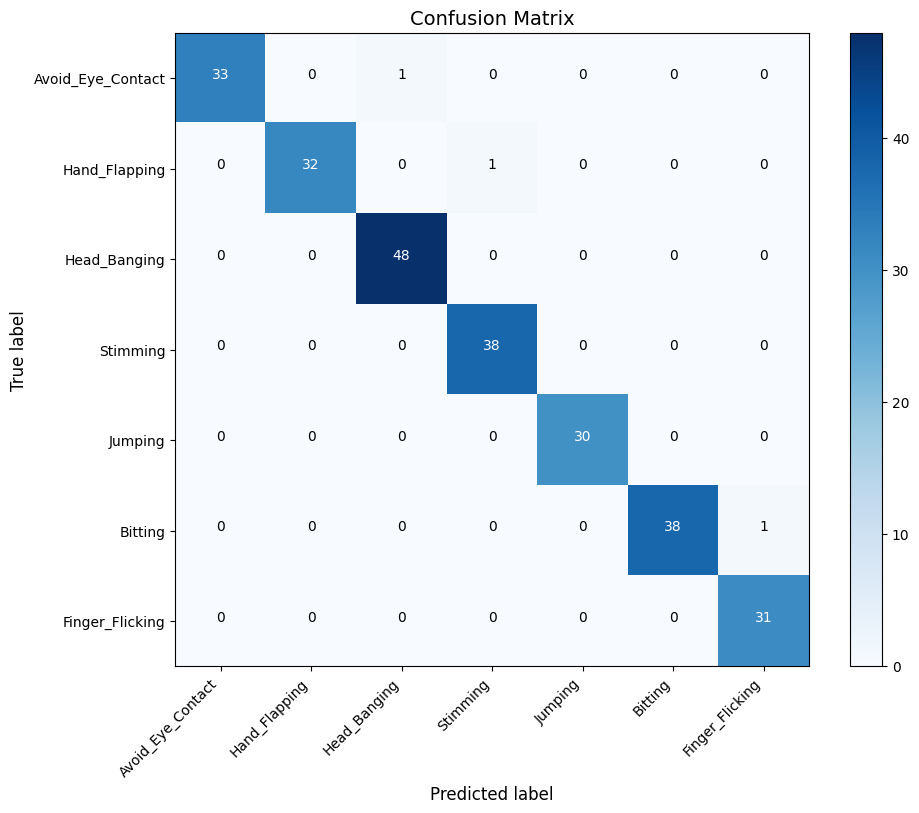

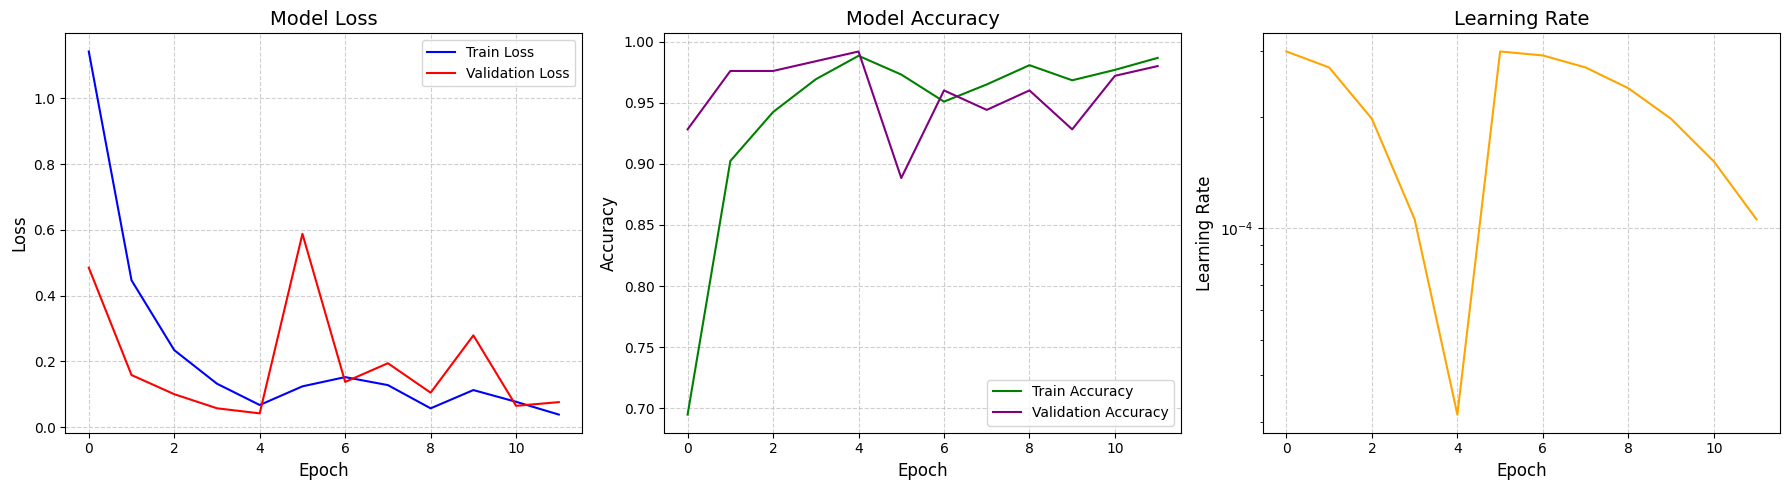


Model Comparison:


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 474.56it/s]

Model Evaluation Results:
Overall Accuracy: 0.8775
F1 Score (weighted): 0.8790

Classification Report:
                   precision    recall  f1-score   support

Avoid_Eye_Contact       0.89      0.91      0.90        34
    Hand_Flapping       0.67      0.91      0.77        33
     Head_Banging       0.92      0.73      0.81        48
         Stimming       0.88      0.97      0.93        38
          Jumping       0.93      0.87      0.90        30
          Bitting       0.97      0.90      0.93        39
  Finger_Flicking       0.97      0.90      0.93        31

         accuracy                           0.88       253
        macro avg       0.89      0.88      0.88       253
     weighted avg       0.89      0.88      0.88       253



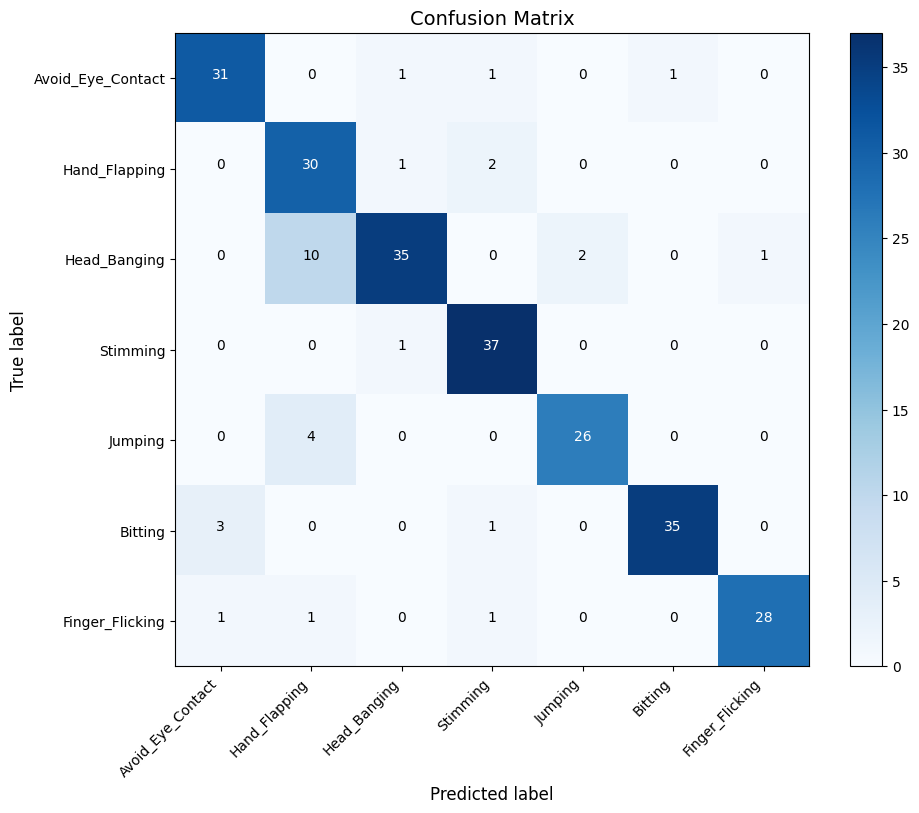

Original Model Accuracy: 0.8775
Improved Model Accuracy: 0.9881
Accuracy Improvement: 11.07%

Feature Engineering Details:
Original features dimension: 34
Enhanced features dimension: 74
Added features:
  - Normalized keypoints
  - Velocity features
  - Advanced biomechanical features
  - Behavior-specific features

Training completed successfully!


In [20]:
def main():
    """
    Main function with complete workflow
    """
    # Initialize paths
    input_videos_dir = '/content/drive/MyDrive/Colab Notebooks/Behavior_videos2'
    keypoints_dir = '/content/drive/MyDrive/Colab Notebooks/Behavior_video/keypoints'
    model_save_path = '/content/drive/MyDrive/Colab Notebooks/improved_behavior_model.pt'
    original_model_save_path = '/content/drive/MyDrive/Colab Notebooks/original_behavior_model.pt'

    # 1. Data collection (uncomment to use)
    print("Step 1: Collecting keypoint data from videos...")
    collect_data(input_videos_dir, keypoints_dir)

    # 2. Dataset preparation
    print("\nStep 2: Preparing dataset...")
    dataset, behavior_names = prepare_dataset(keypoints_dir)
    print(f"Behavior classes: {behavior_names}")

    # Split into train/val/test
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size + test_size])
    val_dataset, test_dataset = torch.utils.data.random_split(
        val_test_dataset, [val_size, test_size])

    print(f"Dataset split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

    # 3. Train original model for comparison
    print("\nStep 3a: Training original model...")
    num_keypoints = 17
    original_input_size = num_keypoints * 2  # x,y coordinates

    # Create original model
    original_model = PoseLSTM(
        input_size=original_input_size,
        hidden_size=128,
        num_layers=2,
        num_classes=len(behavior_names),
        dropout=0.2
    ).to(device)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train original model
    original_model, original_history = train_model(
        original_model,
        train_loader,
        val_loader,
        num_epochs=30
    )

    # Save original model
    torch.save(original_model, original_model_save_path)

    # Evaluate original model
    print("\nEvaluating original model:")
    evaluate_model(original_model, test_loader, behavior_names)

    # Plot original training history
    plot_training_history(original_history)

    # 4. Improved model with enhanced features
    print("\nStep 3b: Preprocessing data with enhanced features...")

    # Apply preprocessing with normalization, velocity, advanced and behavior-specific features
    train_dataset_enhanced = preprocess_dataset(
        train_dataset,
        add_velocity=True,
        add_advanced=True,
        add_behavior=True
    )

    val_dataset_enhanced = preprocess_dataset(
        val_dataset,
        add_velocity=True,
        add_advanced=True,
        add_behavior=True
    )

    test_dataset_enhanced = preprocess_dataset(
        test_dataset,
        add_velocity=True,
        add_advanced=True,
        add_behavior=True
    )

    # Create augmented training dataset with improved augmentation
    print("Creating augmented training dataset...")

    # Get the expected sequence length for consistent sequences
    sample_seq, _ = train_dataset_enhanced[0]
    expected_seq_length = sample_seq.shape[0]

    # Define augmentation function with fixed target length
    def augment_with_length(seq):
        seq_np = seq.numpy()
        augmented = augment_keypoints(seq_np, target_length=expected_seq_length)
        return torch.FloatTensor(augmented)

    # Custom augmented dataset with length preservation
    class ImprovedAugmentedDataset(Dataset):
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset) * 2  # Double the dataset size

        def __getitem__(self, idx):
            real_idx = idx % len(self.dataset)
            seq, label = self.dataset[real_idx]

            # Apply augmentation for half the samples
            if idx >= len(self.dataset):
                seq = augment_with_length(seq)

            return seq, label

    augmented_train_dataset = ImprovedAugmentedDataset(train_dataset_enhanced)

    # Create enhanced data loaders with padding if needed for variable sequence lengths
    class PadCollate:
        """Custom collate function to pad sequences in a batch"""
        def __init__(self, dim=0):
            self.dim = dim

        def __call__(self, batch):
            sequences = [item[0] for item in batch]
            labels = [item[1] for item in batch]

            # Check if sequences have the same length
            if all(seq.shape[0] == sequences[0].shape[0] for seq in sequences):
                # If all the same length, stack directly
                sequences = torch.stack(sequences, dim=0)
            else:
                # Find max length
                max_len = max([s.size(0) for s in sequences])

                # Pad sequences
                padded_seqs = []
                for seq in sequences:
                    if seq.size(0) < max_len:
                        padding = torch.zeros(max_len - seq.size(0), seq.size(1))
                        padded_seq = torch.cat([seq, padding], dim=0)
                        padded_seqs.append(padded_seq)
                    else:
                        padded_seqs.append(seq)

                sequences = torch.stack(padded_seqs, dim=0)

            # Stack labels
            labels = torch.stack([torch.tensor(label) for label in labels], dim=0)

            return sequences, labels

    pad_collate = PadCollate()
    enhanced_train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
    enhanced_val_loader = DataLoader(val_dataset_enhanced, batch_size=32, shuffle=False, collate_fn=pad_collate)
    enhanced_test_loader = DataLoader(test_dataset_enhanced, batch_size=32, shuffle=False, collate_fn=pad_collate)

    # Check the shape of the enhanced features
    sample_seq, _ = train_dataset_enhanced[0]
    enhanced_input_size = sample_seq.shape[1]
    print(f"Enhanced input size: {enhanced_input_size}")
    print(f"Expected sequence length: {expected_seq_length}")

    # Create improved model
    print("\nStep 4: Training improved model...")
    improved_model = ImprovedPoseLSTM(
        input_size=enhanced_input_size,
        hidden_size=256,
        num_layers=2,
        num_classes=len(behavior_names),
        dropout=0.3
    ).to(device)

    # Train with improved training routine
    improved_model, improved_history = improved_train_model(
        improved_model,
        enhanced_train_loader,
        enhanced_val_loader,
        num_epochs=60,
        learning_rate=3e-4
    )

    # Save improved model
    torch.save(improved_model, model_save_path)

    # Evaluate improved model
    print("\nEvaluating improved model:")
    improved_metrics = evaluate_model(improved_model, enhanced_test_loader, behavior_names)

    # Plot improved training history
    plot_training_history(improved_history)

    # 5. Compare models
    print("\nModel Comparison:")
    original_metrics = evaluate_model(original_model, test_loader, behavior_names)

    print(f"Original Model Accuracy: {original_metrics['accuracy']:.4f}")
    print(f"Improved Model Accuracy: {improved_metrics['accuracy']:.4f}")
    print(f"Accuracy Improvement: {(improved_metrics['accuracy'] - original_metrics['accuracy'])*100:.2f}%")

    # Print detailed feature information
    print("\nFeature Engineering Details:")
    print(f"Original features dimension: {original_input_size}")
    print(f"Enhanced features dimension: {enhanced_input_size}")
    print("Added features:")
    print("  - Normalized keypoints")
    print("  - Velocity features")
    print("  - Advanced biomechanical features")
    print("  - Behavior-specific features")

    print("\nTraining completed successfully!")
    return improved_model, behavior_names

if __name__ == "__main__":
    main()

In [25]:
def predict():
    """
    Run prediction on a video file
    """
    try:
        # Create output directory
        os.makedirs('/content/drive/MyDrive', exist_ok=True)

        print("Loading behavior prediction model...")

        # Define behavior names
        behavior_names = ["Avoid_Eye_Contact", "Bitting", "Finger_Flicking",
                          "Hand_Flapping", "Head_Banging", "Jumping", "Stimming"]

        # Initialize the predictor with improved model
        predictor = BehaviorPredictor(
            model_path='/content/drive/MyDrive/Colab Notebooks/improved_behavior_model.pt',
            pose_model_path="yolo11n-pose.pt",
            sequence_length=30,
            behavior_names=behavior_names,
            use_advanced_features=True  # Enable advanced features
        )

        # Process the video
        input_video_path = '/content/drive/MyDrive/Colab Notebooks/Behavior_videos2/Jumping/WhatsApp Video 2025-05-20 at 00.05.47_332bb899 (1).mp4'
        output_video_path = '/content/drive/MyDrive/prediction.mp4'

        print(f"Processing video: {input_video_path}")
        print("This may take some time...")

        behavior_counts = predictor.process_video_realtime(input_video_path, output_video_path)

        print(f"Video processing complete!")
        print(f"Output saved to: {output_video_path}")

        return behavior_counts
    except Exception as e:
        import traceback
        print(f"An error occurred: {e}")
        traceback.print_exc()
        return None

Video processing complete. Last frame:


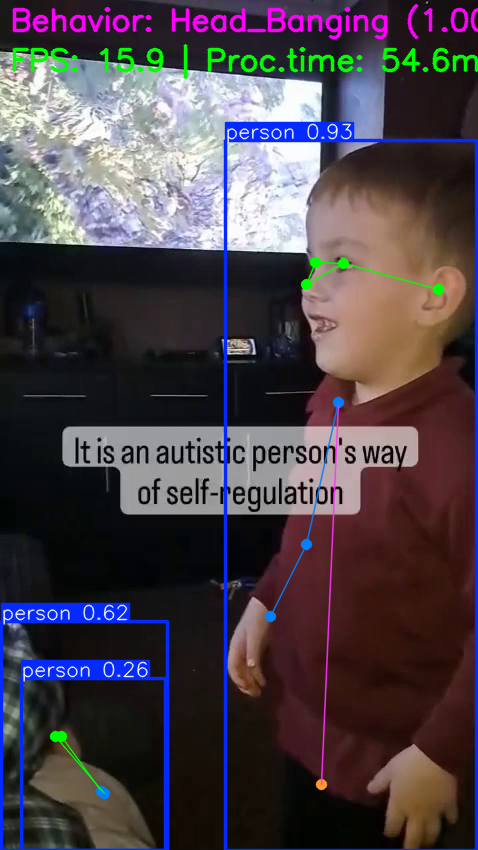


Behavior Statistics:
  Avoid_Eye_Contact: 0 frames (0.0%)
  Bitting: 0 frames (0.0%)
  Finger_Flicking: 0 frames (0.0%)
  Hand_Flapping: 0 frames (0.0%)
  Head_Banging: 271 frames (100.0%)
  Jumping: 0 frames (0.0%)
  Stimming: 0 frames (0.0%)


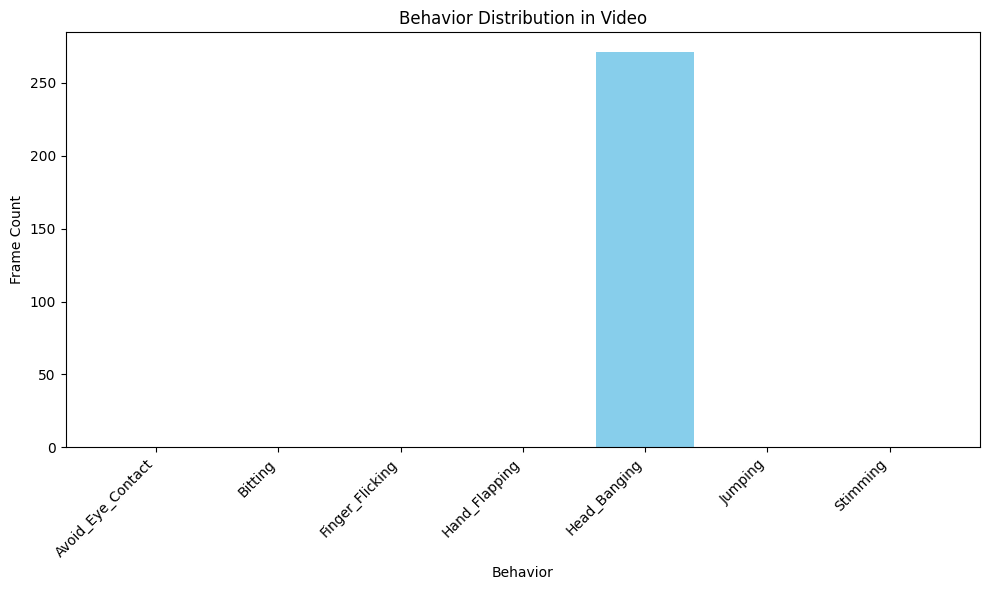

Processing complete. Output saved to: /content/drive/MyDrive/prediction.mp4
Video processing complete!
Output saved to: /content/drive/MyDrive/prediction.mp4


{'Avoid_Eye_Contact': 0,
 'Bitting': 0,
 'Finger_Flicking': 0,
 'Hand_Flapping': 0,
 'Head_Banging': 271,
 'Jumping': 0,
 'Stimming': 0}

In [26]:
predict()